In [1]:
import os
os.chdir(r'/Users/ryanmccrickerd/desktop/jdheston')

In [2]:
import numpy as np
import pandas as pd
from jdheston import jdheston as jdh
from jdheston import utils as uts
from jdheston import config as cfg
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.special import gamma
from scipy.optimize import minimize
# import mpl
# %matplotlib inline

In [3]:
nx = np.newaxis
cfg.config(scale=1.5,print_keys=False)

In [4]:
df = pd.read_excel('data/EURUSD-20190619.xlsx')
df

,EUR,USD,Unnamed: 2,Bloomberg BGN,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,NaN,ATM,NaN,25D Call EUR,NaN,25D Put EUR,NaN,10D Call EUR,NaN,10D Put EUR,NaN
1,NaN,Mid,Spread,Mid,Spread,Mid,Spread,Mid,Spread,Mid,Spread
2,1W,4.918,0.745,5.199,0.937,4.931,0.937,5.602,1.708,5.122,1.711
3,1M,4.878,0.325,5.133,0.408,4.936,0.408,5.505,0.74,5.15,0.74
4,3M,5.23,0.4,5.467,0.502,5.382,0.502,5.889,0.911,5.749,0.911
5,6M,5.632,0.325,5.89,0.408,5.856,0.408,6.418,0.74,6.363,0.74
6,1Y,6.115,0.3,6.383,0.377,6.408,0.377,7.017,0.683,7.082,0.683
7,2Y,6.733,0.375,7.004,0.471,7.051,0.471,7.675,0.853,7.78,0.853


In [5]:
deltas = np.array([0.1,0.25,0.5,0.75,0.9])
expiries = np.array([1/52,1/12,3/12,6/12,1,2])
labels = ['1w','1m','3m','6m','1y','2y']

In [6]:
m,n = len(expiries),len(deltas)
mid_vols = np.zeros((m,n))
spreads = np.zeros((m,n))

In [7]:
mid_vols[:,0] = df.iloc[2:,9]
mid_vols[:,1] = df.iloc[2:,5]
mid_vols[:,2] = df.iloc[2:,1]
mid_vols[:,3] = df.iloc[2:,3]
mid_vols[:,4] = df.iloc[2:,7]

In [8]:
spreads[:,0] = df.iloc[2:,10]
spreads[:,1] = df.iloc[2:,6]
spreads[:,2] = df.iloc[2:,2]
spreads[:,3] = df.iloc[2:,4]
spreads[:,4] = df.iloc[2:,8]

In [9]:
plt.rcParams['figure.figsize'] = [4,12]
plt.rcParams['legend.loc'] = 'lower left'

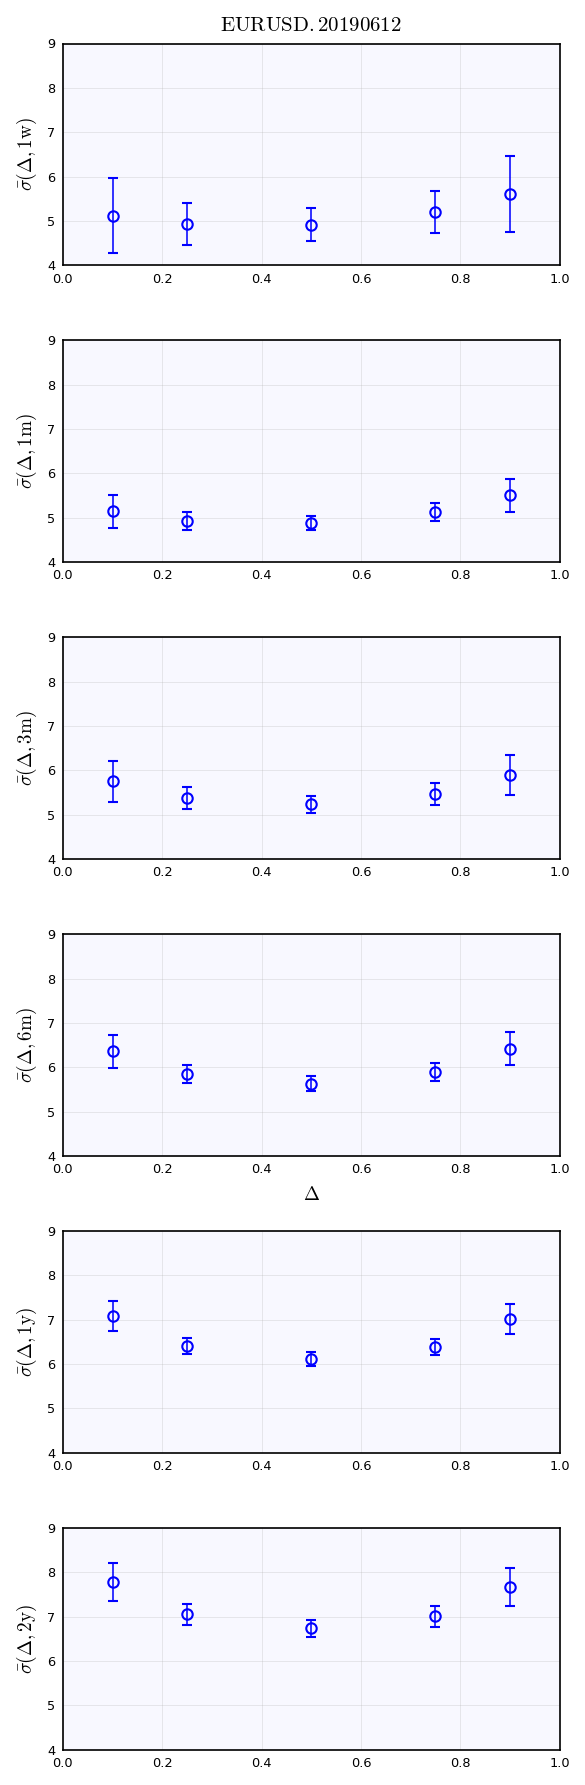

In [10]:
plot,axes = plt.subplots(m)
for i in range(m):
        axes[i].plot(deltas, mid_vols[i,:],'bo')
        
        for j in range(n):
            axes[i].plot([deltas[j],deltas[j]], [mid_vols[i,j] - spreads[i,j]/2,mid_vols[i,j] + spreads[i,j]/2],'b')
        axes[i].plot(deltas, mid_vols[i,:] + spreads[i,:]/2,'b_')
        axes[i].plot(deltas, mid_vols[i,:] - spreads[i,:]/2,'b_')
        axes[i].set_ylabel(r'$\bar{\sigma}(\Delta,\mathrm{%s})$'%labels[i])
        axes[i].set_ylim([4,9])
        axes[i].set_xlim([0,1])
axes[0].set_title(r'$\mathrm{EURUSD.20190612}$')
axes[3].set_xlabel(r'$\Delta$')
plt.tight_layout()

In [11]:
vols = mid_vols/100

In [12]:
vol_surface = jdh.vol_surface(expiries[:,nx], deltas[nx,:], vols)

In [13]:
vol_surface.fit_jheston()

/Users/ryanmccrickerd/Desktop/jdheston/jdheston/jdheston.py:218: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p = 1 - 1/np.pi*np.exp(k/2)*quad(jheston_integrand,0,u,args=(t,k,Θ))[0]
/Users/ryanmccrickerd/Desktop/jdheston/jdheston/jdheston.py:210: RuntimeWarning: invalid value encountered in cdouble_scalars
  return np.exp((1 - a - np.sqrt((1 - a)**2 + (σ*v)**2*u*(i + u)))/v**2*t)
/Users/ryanmccrickerd/Desktop/jdheston/jdheston/jdheston.py:218: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The erro

,sigma,rho,vee,rmse
0.019231,0.052056,0.124557,0.100010,0.000098
0.083333,0.051702,0.093835,0.209557,0.000125
0.250000,0.056091,0.036718,0.412047,0.000115
0.500000,0.061197,0.019826,0.654188,0.000100
1.000000,0.067135,0.005837,1.009250,0.000054
2.000000,0.073677,0.008736,1.397864,0.000041


In [14]:
sigma_max = np.max(vol_surface.jheston['sigma'])
sigma_max

0.07367681918278401

In [15]:
T = np.array([1/52,1/12,3/12,6/12,1,2])[:,nx]
# M = ['1W','1M','3M','6M','9M','1Y']
Δ = np.linspace(5,95,19)[nx,:]/100
k = norm.ppf(Δ)*sigma_max*np.sqrt(T)

In [16]:
pd.DataFrame(k,index=T[:,0],columns=np.round(Δ[0,:],2))

,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
0.019231,-0.016806,-0.013094,-0.010589,-0.008599,-0.006891,-0.005358,-0.003937,-0.002588,-0.001284,0.0,0.001284,0.002588,0.003937,0.005358,0.006891,0.008599,0.010589,0.013094,0.016806
0.083333,-0.034984,-0.027257,-0.022044,-0.017900,-0.014345,-0.011153,-0.008195,-0.005388,-0.002673,0.0,0.002673,0.005388,0.008195,0.011153,0.014345,0.017900,0.022044,0.027257,0.034984
0.250000,-0.060594,-0.047210,-0.038181,-0.031004,-0.024847,-0.019318,-0.014195,-0.009333,-0.004629,0.0,0.004629,0.009333,0.014195,0.019318,0.024847,0.031004,0.038181,0.047210,0.060594
0.500000,-0.085693,-0.066765,-0.053995,-0.043846,-0.035139,-0.027320,-0.020074,-0.013199,-0.006547,0.0,0.006547,0.013199,0.020074,0.027320,0.035139,0.043846,0.053995,0.066765,0.085693
1.000000,-0.121188,-0.094421,-0.076361,-0.062008,-0.049694,-0.038636,-0.028389,-0.018666,-0.009258,0.0,0.009258,0.018666,0.028389,0.038636,0.049694,0.062008,0.076361,0.094421,0.121188
2.000000,-0.171385,-0.133531,-0.107991,-0.087693,-0.070278,-0.054640,-0.040148,-0.026397,-0.013093,0.0,0.013093,0.026397,0.040148,0.054640,0.070278,0.087693,0.107991,0.133531,0.171385


In [17]:
vol_surface.jheston

,sigma,rho,vee,rmse
0.019231,0.052056,0.124557,0.100010,0.000098
0.083333,0.051702,0.093835,0.209557,0.000125
0.250000,0.056091,0.036718,0.412047,0.000115
0.500000,0.061197,0.019826,0.654188,0.000100
1.000000,0.067135,0.005837,1.009250,0.000054
2.000000,0.073677,0.008736,1.397864,0.000041


In [18]:
sigma = np.array(vol_surface.jheston['sigma'])
sigma

array([0.05205575, 0.05170224, 0.05609079, 0.06119652, 0.06713517,
       0.07367682])

In [19]:
average_vols = np.array(vol_surface.jheston['sigma'].copy())
forward_vols = average_vols.copy()
for i in np.arange(1,m):
    forward_vols[i] = np.sqrt((average_vols[i]**2*T[i,0] - average_vols[i-1]**2*T[i-1,0])/(T[i,0] - T[i-1,0]))

In [20]:
forward_vols

array([0.05205575, 0.05159571, 0.05816102, 0.0659079 , 0.07258959,
       0.07968322])

In [21]:
jump_weight = 0.5
jump_sigma = jump_weight**0.5*forward_vols
diff_sigma = (1 - jump_weight)**0.5*forward_vols
jump_sigma, diff_sigma

(array([0.03680897, 0.03648368, 0.04112605, 0.04660392, 0.05132859,
        0.05634455]),
 array([0.03680897, 0.03648368, 0.04112605, 0.04660392, 0.05132859,
        0.05634455]))

In [22]:
times1   = np.array([0,1/52,1/12,3/12,6/12,1])
sigma1   = jump_sigma
rho1     = np.array([ +0.5])*np.ones_like(times1)
vee1     = np.array([1.0])*np.ones_like(times1)
epsilon1 = np.array([ 0])*np.ones_like(times1)

In [23]:
times2   = np.array([0,1/52,1/12,3/12,6/12,1])
sigma2   = diff_sigma
rho2     = np.array([-0.9])*np.ones_like(times2)
vee2     = np.array([2.5])*np.ones_like(times2)
epsilon2 = np.array([ 0.5])*np.ones_like(times2)

In [24]:
params1  = np.array([times1, sigma1, rho1, vee1, epsilon1]).T
params2  = np.array([times2, sigma2, rho2, vee2, epsilon2]).T

In [25]:
params1.shape

(6, 5)

In [26]:
maturities = T
logstrikes = k

In [27]:
eps1 = 1/12
eps2 = 1

In [28]:
T = vol_surface.expiries
k = vol_surface.logstrikes
vols = vol_surface.vols

In [29]:
def rmse(x):
    jump_weight, rho1, rho2, vee1, vee2, eps1 = x
    
    jump_sigma = jump_weight**0.5*forward_vols
    diff_sigma = (1 - jump_weight)**0.5*forward_vols
    
    sigma1   = jump_sigma
    rho1     = np.array([rho1])*np.ones_like(sigma1)
    vee1     = np.array([vee1])*np.ones_like(sigma1)
    epsilon1 = np.array([eps1])*np.ones_like(sigma1)
    
    sigma2   = diff_sigma
    rho2     = np.array([rho2])*np.ones_like(sigma2)
    vee2     = np.array([vee2])*np.ones_like(sigma2)
    epsilon2 = np.array([eps2])*np.ones_like(sigma2)
    
    params1  = np.array([times1, sigma1, rho1, vee1, epsilon1]).T
    params2  = np.array([times2, sigma2, rho2, vee2, epsilon2]).T
    
    call_prices = jdh.jdh2f_pricer(T, k, [params1, params2])
    model_vols = jdh.surface(T, k, call_prices)
    
    rmse = np.sqrt(np.mean((model_vols - vols)**2))
    return 100*rmse

In [30]:
x0 = 0.31387633,  0.52019328, -0.2088945 ,  1.57265236,  2.85777822, 1/12 # for epsilon = 1.0

In [31]:
results = minimize(rmse, x0,
                   method = 'L-BFGS-B',
                   # args = (expiry, logstrikes, vols),
                   bounds = ((0.01,0.99), (-1,1), (-1,1), (0,None), (0,None), (0,None)),
                   options = {'maxiter': 50}
              )
results

      fun: 0.04389779831630458
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.01158534e-05,  1.15796261e-05,  1.28660971e-05,  1.07691633e-05,
        1.53765889e-05,  9.86988269e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 329
      nit: 36
   status: 0
  success: True
        x: array([ 0.29388978,  0.42340366, -0.0906377 ,  0.70271526,  3.69520297,
        0.01545663])

In [32]:
jump_weight, rho1, rho2, vee1, vee2, eps1 = results.x

In [33]:
T = np.array([1/52,1/12,3/12,6/12,1,2])[:,nx]
# M = ['1W','1M','3M','6M','9M','1Y']
Δ = np.linspace(5,95,19)[nx,:]/100
k = norm.ppf(Δ)*0.09*np.sqrt(T)

In [34]:
jump_sigma = jump_weight**0.5*forward_vols
diff_sigma = (1 - jump_weight)**0.5*forward_vols

sigma1   = jump_sigma
rho1     = np.array([rho1])*np.ones_like(sigma1)
vee1     = np.array([vee1])*np.ones_like(sigma1)

sigma2   = diff_sigma
rho2     = np.array([rho2])*np.ones_like(sigma2)
vee2     = np.array([vee2])*np.ones_like(sigma2)
epsilon2 = np.array([eps2])*np.ones_like(sigma2)

params1  = np.array([times1, sigma1, rho1, vee1, epsilon1]).T
params2  = np.array([times2, sigma2, rho2, vee2, epsilon2]).T

call_prices = jdh.jdh2f_pricer(T, k, [params1, params2])
implied_vols = jdh.surface(T, k, call_prices)
    
implied_vars = implied_vols*np.sqrt(T)
Δ = norm.cdf(k/implied_vars + 0.5*implied_vars)

In [35]:
plt.rcParams['legend.loc'] = 'upper left'

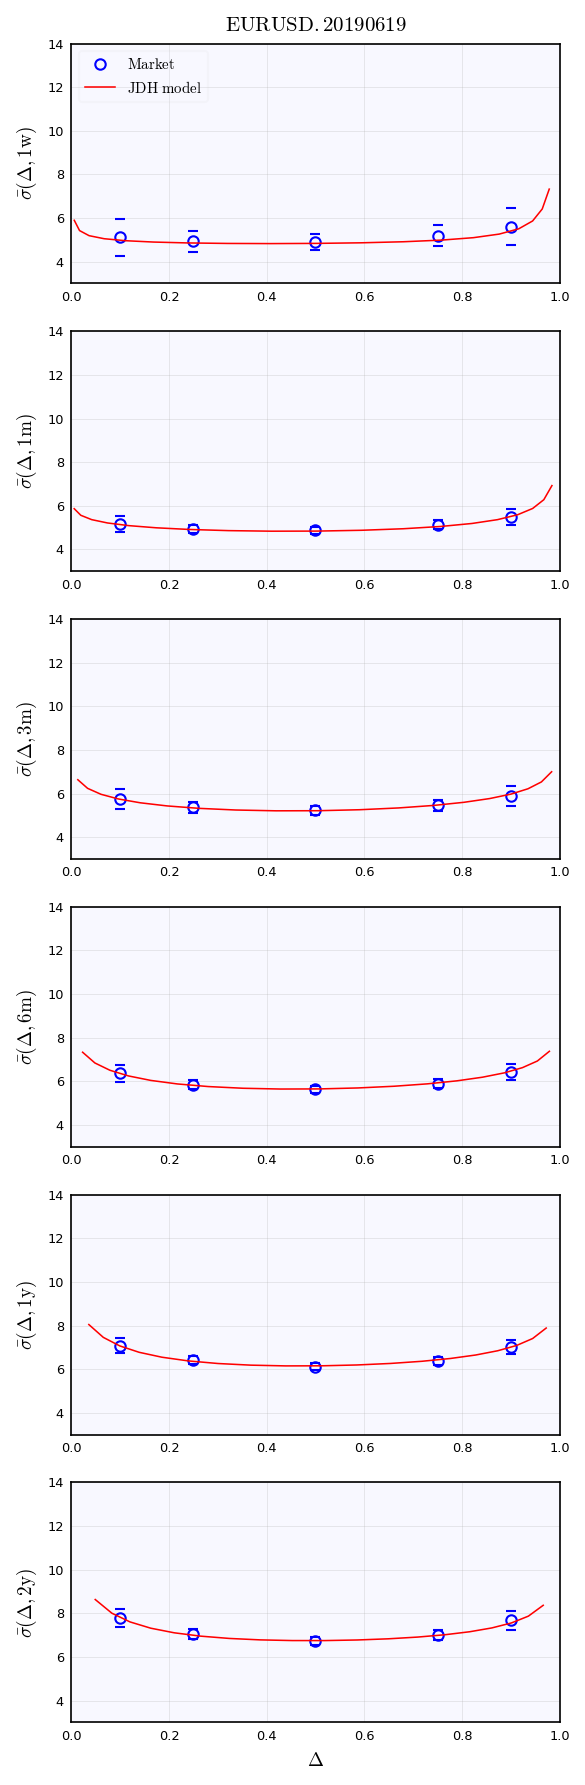

In [36]:
plot,axes = plt.subplots(m)
for i in range(len(T[:,0])):
    axes[i].plot(deltas, mid_vols[i,:],'bo')
    axes[i].plot(Δ[i,:],100*implied_vols[i,:])
    
    axes[i].plot(deltas, mid_vols[i,:] + spreads[i,:]/2,'b_')
    axes[i].plot(deltas, mid_vols[i,:] - spreads[i,:]/2,'b_')
    
    axes[i].set_xlim([0,1])
    axes[i].set_ylim([3,14])
    axes[i].set_ylabel(r'$\bar{\sigma}(\Delta,\mathrm{%s})$'%labels[i])
axes[0].set_title(r'$\mathrm{EURUSD.20190619}$')
axes[0].legend([r'$\mathrm{Market}$',r'$\mathrm{JDH\ model}$'])
axes[-1].set_xlabel(r'$\Delta$')
plt.tight_layout()
plt.savefig('plots/EURUSD-20190619')

In [37]:
from cycler import cycler
plt.rcParams['figure.figsize'] = [4,4/1.618]
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['axes.prop_cycle'] = cycler(color=['r','coral','gold','g','b','indigo'])

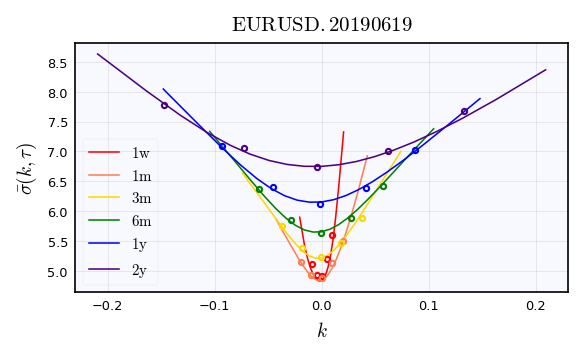

In [38]:
plot,axes = plt.subplots()
for i in range(len(T[:,0])):
    axes.plot(k[i,:],100*implied_vols[i,:])
for i in range(len(T[:,0])):
    axes.plot(vol_surface.logstrikes[i,:],100*vol_surface.vols[i,:],marker='.',linestyle='')
    
axes.legend([r'$\mathrm{1w}$',
             r'$\mathrm{1m}$',
             r'$\mathrm{3m}$',
             r'$\mathrm{6m}$',
             r'$\mathrm{1y}$',
             r'$\mathrm{2y}$'])
axes.set_ylabel(r'$\bar{\sigma}(k,\tau)$')
axes.set_title(r'$\mathrm{EURUSD.20190619}$')
# axes.legend([r'$\mathrm{JDH\ model}$'])
axes.set_xlabel(r'$k$')
plt.tight_layout()
plt.savefig('plots/EURUSD-20190619-surface')